In [1]:
class mset_regress():

    def __init__(self):
        self.hat_array = None  # model이 되는 hat_matrix 저장
        self.UCL = None
        self.LCL = None
        self.varucl = []
        self.varlcl = []
        self.cov_scaler = msetLR_covariance_scaler()

    def fit(self, trdat, alpha=0.05):
        """

        Parameters
        ----------
        trdat : array
            학습 데이터
        alpha : float, 0~1, default = 0.05
            Control limit의 유의 수준
        Returns
        -------
        trScore : array
            Mset Linearregresion의 Train 잔차 (이상감지 통계량)

        """

        train_intercept = np.ones((trdat.shape[0], 1))
        y_hat_tr = np.zeros((trdat.shape[0], trdat.shape[1]))
        self.hat_array = np.zeros((len(trdat.columns), len(trdat.columns)))

        for i in range(len(trdat.columns)):
            trainX = np.concatenate((train_intercept, np.delete(trdat.values, i, axis=1)), axis=1)
            trainY = trdat.values[:, i]

            self.hat_array[:, i] = np.linalg.pinv(trainX.transpose() @ trainX) @ trainX.transpose() @ trainY
            y_hat_tr[:, i] = trainX @ self.hat_array[:, i]

            # 각 변수 별 Trscore
        varTrScore = trdat.values - y_hat_tr

        # Trscore rowsum
        self.cov_scaler.fit(trdat)  # cov scaler 학습
        scaled_varTrScore = self.cov_scaler.transform(varTrScore)  # 변환
        trScore = L2norm(scaled_varTrScore).sum(axis=1)  # L2norm

        ## CL
        # 각 변수 별 CL
        for i in range(len(trdat.columns)):
            self.varucl.append(bootstrap_limit(scaled_varTrScore[:, i], alpha=alpha / 2))
            self.varlcl.append(bootstrap_limit(scaled_varTrScore[:, i], alpha=alpha / 2, upper=False))

        # 합산 CL
        self.UCL = bootstrap_limit(trScore, alpha=alpha)
        self.LCL = self.UCL

        return {'trScore': trScore, 'varTrScore': scaled_varTrScore}

    def CL_printor(self):
        """

        Returns
        -------
        UCL, LCL: float
            upper, lower Control Limit,
        varUCL, varLCL :
            변수 별  UCL, LCL

        """

        return {'UCL': self.UCL, 'LCL': self.LCL, 'varUCL': self.varucl, 'varLCL': self.varlcl}

    def predict(self, tsdat):
        """

        Parameters
        ----------
        tsdat : array
            예측 데이터

        Returns
        -------
        tsScore : array
            Mset RandomForest의 Test 잔차 (이상감지 통계량)

        """
        if isinstance(tsdat, pd.DataFrame):
            tsdat = tsdat.values
            delete_axis = 1
        if isinstance(tsdat, pd.core.series.Series):
            tsdat = tsdat.values

        if tsdat.ndim == 1:
            num_rows, num_columns = tsdat.shape[0], 1
            delete_axis = None
            test_intercept = np.ones((1))

            # 변수 별 연산
            y_hat_ts = np.zeros((num_rows))
            for i in range(num_columns):
                testX = np.concatenate((test_intercept, np.delete(tsdat, i, axis=delete_axis)), axis=delete_axis)
                y_hat_ts[i] = testX @ self.hat_array[i]

            # Row Sum
            varTsScore = tsdat - y_hat_ts
            scaled_varTsScore = self.cov_scaler.transform(varTsScore)  # 변환
            tsScore = L2norm(scaled_varTsScore).sum(axis=0)  # L2norm

        # tsdat.dim != 1
        else:
            num_rows, num_columns = tsdat.shape[0], tsdat.shape[1]
            delete_axis = 1
            test_intercept = np.ones((num_rows, 1))

            # 변수 별 연산
            y_hat_ts = np.zeros((num_rows, num_columns))
            for i in range(num_columns):
                testX = np.concatenate((test_intercept, np.delete(tsdat, i, axis=delete_axis)), axis=delete_axis)
                y_hat_ts[:, i] = testX @ self.hat_array[:, i]

            # Row Sum
            varTsScore = tsdat - y_hat_ts
            scaled_varTsScore = self.cov_scaler.transform(varTsScore)  # 변환
            tsScore = L2norm(scaled_varTsScore).sum(axis=1)  # L2norm

        return {'Tsscore': tsScore, 'Vartsscore': scaled_varTsScore}

In [17]:
import numpy as np

def L2norm(stat):
    return(np.sqrt(stat**2))

def matrix_inv(matrix):
    return np.linalg.pinv(matrix)

# covariance scaler
class msetLR_covariance_scaler() :
    
    def __init__(self) :
        
        self.cov_inv_matrix = None
            
    def fit(self, trdat):
        
        cov_mat = np.cov(trdat.transpose())
        self.cov_inv_matrix = matrix_inv(cov_mat)
        
    def transform(self, tsdat) :
        if isinstance(tsdat, list) :
            tsdat = np.array(tsdat).transpose()
            
        scaled_residual = np.dot(np.array(tsdat), self.cov_inv_matrix)
        return scaled_residual

In [69]:
import numpy as np
class mset_regress():
    
    def __init__(self):
        self.hat_array = None  # model이 되는 hat_matrix 저장
        self.UCL = None
        self.LCL = None
        self.varucl = []
        self.varlcl = []
        self.cov_scaler = msetLR_covariance_scaler()  
        
    def fit(self, trdat, alpha=0.05):
        """

        Parameters
        ----------
        trdat : array
            학습 데이터
        alpha : float, 0~1, default = 0.05
            Control limit의 유의 수준
        Returns
        -------
        trScore : array
            Mset Linearregresion의 Train 잔차 (이상감지 통계량)

        """
        train_intercept = np.ones((trdat.shape[0], 1))
        y_hat_tr = np.zeros((trdat.shape[0], trdat.shape[1]))
        self.hat_array = np.zeros((trdat.shape[1], trdat.shape[1]))
        
        for i in range(trdat.shape[1]):
            trainX = np.concatenate((train_intercept, np.delete(trdat.values, i, axis=1)), axis=1)
            trainY = trdat.values[:, i]

            self.hat_array[:, i] = np.linalg.pinv(trainX.transpose() @ trainX) @ trainX.transpose() @ trainY
            y_hat_tr[:, i] = trainX @ self.hat_array[:, i]

In [40]:
class mset_regress():

    def __init__(self):
        self.hat_array = None  # model이 되는 hat_matrix 저장
        self.UCL = None
        self.LCL = None
        self.varucl = []
        self.varlcl = []
        self.cov_scaler = msetLR_covariance_scaler()

    def fit(self, trdat, alpha=0.05):
        """

        Parameters
        ----------
        trdat : array
            학습 데이터
        alpha : float, 0~1, default = 0.05
            Control limit의 유의 수준
        Returns
        -------
        trScore : array
            Mset Linearregresion의 Train 잔차 (이상감지 통계량)

        """

        train_intercept = np.ones((trdat.shape[0], 1))
        y_hat_tr = np.zeros((trdat.shape[0], trdat.shape[1]))
        self.hat_array = np.zeros((trdat.shape[1], trdat.shape[1])

        for i in range(1):
            trainX = np.concatenate((train_intercept, np.delete(trdat.values, i, axis=1)), axis=1)
            trainY = trdat.values[:, i]

            self.hat_array[:, i] = np.linalg.pinv(trainX.transpose() @ trainX) @ trainX.transpose() @ trainY
            y_hat_tr[:, i] = trainX @ self.hat_array[:, i]

            # 각 변수 별 Trscore
        varTrScore = trdat.values - y_hat_tr

        # Trscore rowsum
        self.cov_scaler.fit(trdat)  # cov scaler 학습
        scaled_varTrScore = self.cov_scaler.transform(varTrScore)  # 변환
        trScore = L2norm(scaled_varTrScore).sum(axis=1)  # L2norm

        ## CL
        # 각 변수 별 CL
        for i in range(trdat.shape[1]):
            self.varucl.append(bootstrap_limit(scaled_varTrScore[:, i], alpha=alpha / 2))
            self.varlcl.append(bootstrap_limit(scaled_varTrScore[:, i], alpha=alpha / 2, upper=False))

        # 합산 CL
        self.UCL = bootstrap_limit(trScore, alpha=alpha)
        self.LCL = self.UCL

        return {'trScore': trScore, 'varTrScore': scaled_varTrScore}

SyntaxError: invalid syntax (2779347484.py, line 31)

In [37]:
class mset_regress():

    def __init__(self):
        self.hat_array = None  # model이 되는 hat_matrix 저장
        self.UCL = None
        self.LCL = None
        self.varucl = []
        self.varlcl = []
        self.cov_scaler = msetLR_covariance_scaler()

    def fit(self, trdat, alpha=0.05):
        """

        Parameters
        ----------
        trdat : array
            학습 데이터
        alpha : float, 0~1, default = 0.05
            Control limit의 유의 수준
        Returns
        -------
        trScore : array
            Mset Linearregresion의 Train 잔차 (이상감지 통계량)

        """

        train_intercept = np.ones((trdat.shape[0], 1))
        y_hat_tr = np.zeros((trdat.shape[0], trdat.shape[1]))
        self.hat_array = np.zeros((trdat.shape[1], trdat.shape[1])

        for i in range(len(trdat.columns)):
            trainX = np.concatenate((train_intercept, np.delete(trdat.values, i, axis=1)), axis=1)
            trainY = trdat.values[:, i]

            self.hat_array[:, i] = np.linalg.pinv(trainX.transpose() @ trainX) @ trainX.transpose() @ trainY
            y_hat_tr[:, i] = trainX @ self.hat_array[:, i]

            # 각 변수 별 Trscore
        varTrScore = trdat.values - y_hat_tr

        # Trscore rowsum
        self.cov_scaler.fit(trdat)  # cov scaler 학습
        scaled_varTrScore = self.cov_scaler.transform(varTrScore)  # 변환
        trScore = L2norm(scaled_varTrScore).sum(axis=1)  # L2norm

        ## CL
        # 각 변수 별 CL
        for i in range(trdat.shape[1]:
            self.varucl.append(bootstrap_limit(scaled_varTrScore[:, i], alpha=alpha / 2))
            self.varlcl.append(bootstrap_limit(scaled_varTrScore[:, i], alpha=alpha / 2, upper=False))

        # 합산 CL
        self.UCL = bootstrap_limit(trScore, alpha=alpha)
        self.LCL = self.UCL

        return {'trScore': trScore, 'varTrScore': scaled_varTrScore}

    def CL_printor(self):
        """

        Returns
        -------
        UCL, LCL: float
            upper, lower Control Limit,
        varUCL, varLCL :
            변수 별  UCL, LCL

        """

        return {'UCL': self.UCL, 'LCL': self.LCL, 'varUCL': self.varucl, 'varLCL': self.varlcl}

    def predict(self, tsdat):
        """

        Parameters
        ----------
        tsdat : array
            예측 데이터

        Returns
        -------
        tsScore : array
            Mset RandomForest의 Test 잔차 (이상감지 통계량)

        """
        if isinstance(tsdat, pd.DataFrame):
            tsdat = tsdat.values
            delete_axis = 1
        if isinstance(tsdat, pd.core.series.Series):
            tsdat = tsdat.values

        if tsdat.ndim == 1:
            num_rows, num_columns = tsdat.shape[0], 1
            delete_axis = None
            test_intercept = np.ones((1))

            # 변수 별 연산
            y_hat_ts = np.zeros((num_rows))
            for i in range(num_columns):
                testX = np.concatenate((test_intercept, np.delete(tsdat, i, axis=delete_axis)), axis=delete_axis)
                y_hat_ts[i] = testX @ self.hat_array[i]

            # Row Sum
            varTsScore = tsdat - y_hat_ts
            scaled_varTsScore = self.cov_scaler.transform(varTsScore)  # 변환
            tsScore = L2norm(scaled_varTsScore).sum(axis=0)  # L2norm

        # tsdat.dim != 1
        else:
            num_rows, num_columns = tsdat.shape[0], tsdat.shape[1]
            delete_axis = 1
            test_intercept = np.ones((num_rows, 1))

            # 변수 별 연산
            y_hat_ts = np.zeros((num_rows, num_columns))
            for i in range(num_columns):
                testX = np.concatenate((test_intercept, np.delete(tsdat, i, axis=delete_axis)), axis=delete_axis)
                y_hat_ts[:, i] = testX @ self.hat_array[:, i]

            # Row Sum
            varTsScore = tsdat - y_hat_ts
            scaled_varTsScore = self.cov_scaler.transform(varTsScore)  # 변환
            tsScore = L2norm(scaled_varTsScore).sum(axis=1)  # L2norm

        return {'Tsscore': tsScore, 'Vartsscore': scaled_varTsScore}
    
    
def mset_LinearRegression(trdat, tsdat, alpha = 0.05) :

    model = mset_regress()
    fit = model.fit(trdat, alpha)
    CL = model.CL_printor()
    pred = model.predict(tsdat)

    # model pickle 저장
    # saved_model = joblib.dump(model, 'mset_LR.pkl')

    return {'trScore' : fit['trScore'], 'tsScore' : pred['Tsscore'], 'UCL' : CL['UCL'], 'LCL' : CL['LCL'],
        'varTrScore' : fit['varTrScore'], 'Vartsscore' : pred['Vartsscore'], 'varUCL' : CL['varUCL'], 'varLCL' : CL['varLCL']}

SyntaxError: invalid syntax (500971534.py, line 31)

In [2]:
def mset_LinearRegression(trdat, tsdat, alpha = 0.05) :
    
    model = mset_regress()
    fit = model.fit(trdat, alpha)
    CL = model.CL_printor()
    pred = model.predict(tsdat)
    
    # model pickle 저장
    # saved_model = joblib.dump(model, 'mset_LR.pkl')
    
    return {'trScore' : fit['trScore'], 'tsScore' : pred['Tsscore'], 'UCL' : CL['UCL'], 'LCL' : CL['LCL'],
            'varTrScore' : fit['varTrScore'], 'Vartsscore' : pred['Vartsscore'], 'varUCL' : CL['varUCL'], 'varLCL' : CL['varLCL']}

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [11]:
df = pd.read_csv('./data/shot6_3D365-48910.csv', encoding='euc-kr')

In [15]:
var0 = np.where(round(df.describe().iloc[2,:], 5)  == 0)[0]

arr = np.delete(df.values, var0, axis=1)

labels = df['판정코드']

# train 정상, test 정상
in_train, in_test = train_test_split(arr[labels == 0], test_size=0.3, shuffle=False)

# test 이상
out_test = arr[labels == 1]

# test
test = np.concatenate([in_test, out_test], axis=0)

In [21]:
def bootstrap_limit(stat, alpha=0.05, bootstrap=100, upper = True):
    '''
        @Description
            Bootstrap sampling을 활용한 Control Limit 산출 기법

        @Parameter
            stat : 통계량 (정상상태의 데이터 입력)
            alpha : Control Limit을 정하기 위한 유의수준 (0~1)
            bootstrap : 샘플링 횟수
        @Return
            limit : 임계값 (CL : Control Limit)
    '''
    
    alpha = alpha * 100
    if(upper) : alpha = 100 - alpha
    samsize = max(100, len(stat))
    
    stat = stat.reshape(len(stat)) # 2차원 array를 1차원 array로 변환
    
    # bootstrap 수 만큼 다음 작업을 반복 : samsize(최소 10000번)만큼 정상상태 데이터를 유의수준 만큼 복원 추출 후 평균 값 사용 
    limit = np.mean(list(map(lambda x:np.percentile(np.random.choice(stat,samsize,replace=True),alpha), range(0,bootstrap))))
    
    return limit

In [22]:
model = mset_LinearRegression(pd.DataFrame(in_train[:,2:]), pd.DataFrame(test[:,2:]), alpha=0.05)

In [24]:
model = mset_LinearRegression(in_train[:,2:], test[:,2:], alpha=0.05)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [302]:
model['UCL']

765.5585713001057

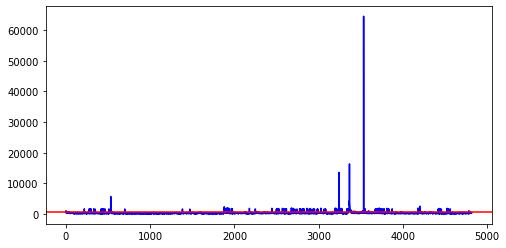

In [312]:
plt.figure(figsize=(8,4))
plt.plot(model['trScore'], color='blue')
plt.axhline(y=model['UCL'], color='red')
# plt.plot(model['varTrScore'][:,idx], color='green')
plt.show()

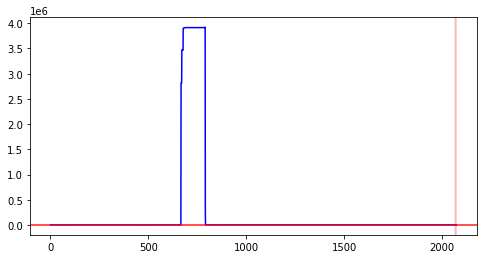

In [316]:

plt.figure(figsize=(8,4))
plt.plot(model['tsScore'], color='blue')
# plt.plot(model['varTrScore'][:,idx], color='green')
plt.axhline(y=model['UCL'], color='red', alpha=0.9)
for i in range(8):
    plt.axvline(x=np.arange(len(model['tsScore'])-8, len(model['tsScore']))[i], alpha=0.05, color='red')

plt.show()

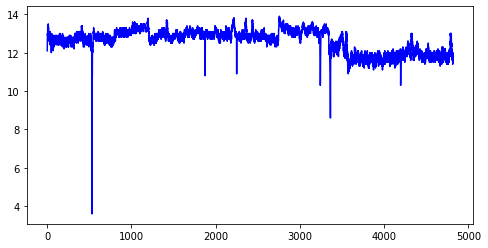

In [329]:
idx = 5
plt.figure(figsize=(8,4))
plt.plot(in_train[:,2+idx], color='blue')
# plt.plot(model['varTrScore'][:,idx], color='green')

plt.show()

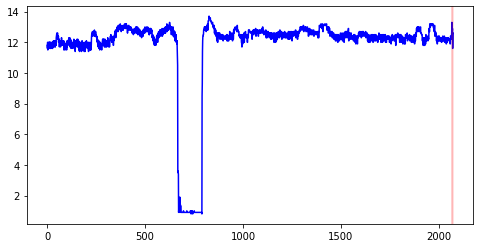

In [330]:
idx = 5
plt.figure(figsize=(8,4))
plt.plot(test[:,2+idx], color='blue')
# plt.plot(model['varTrScore'][:,idx], color='green')
for i in range(8):
    plt.axvline(x=np.arange(len(model['tsScore'])-8, len(model['tsScore']))[i], alpha=0.05, color='red')

plt.show()

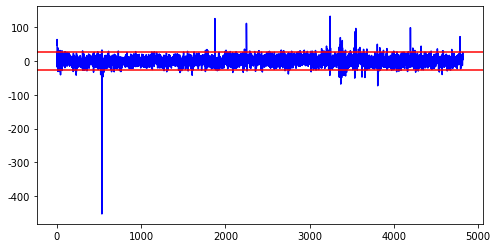

In [331]:
idx = 5
plt.figure(figsize=(8,4))
plt.plot(model['varTrScore'][:,idx], color='blue')
# plt.plot(model['varTrScore'][:,idx], color='green')
plt.axhline(y=model['varLCL'][idx], color='red')
plt.axhline(y=model['varUCL'][idx], color='red')
plt.show()

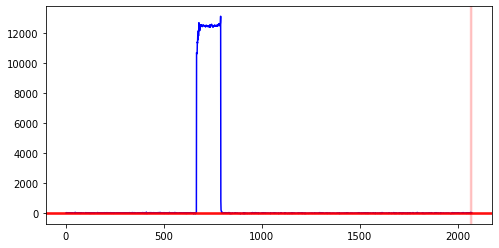

쿠션위치


In [332]:
idx = 5
plt.figure(figsize=(8,4))
plt.plot(model['Vartsscore'][:,idx], color='blue')
# plt.plot(model['varTrScore'][:,idx], color='green')
plt.axhline(y=model['varLCL'][idx], color='red')
plt.axhline(y=model['varUCL'][idx], color='red')

for i in range(8):
    plt.axvline(x=np.arange(len(model['tsScore'])-8, len(model['tsScore']))[i], alpha=0.05, color='red')

plt.show()

print(df.drop(df.columns[var0], axis=1).columns[idx+2])